In [1]:
import os
import numpy as np
import pandas as pd
from trackml.dataset import load_event
from trackml.randomize import shuffle_hits
from trackml.score import score_event
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.pyplot as plt
from hough import *
from conformal_map import *
from tqdm import tqdm

%matplotlib inline

In [2]:
event_prefix = 'event000001000'
hits, cells, particles, truth = load_event(os.path.join('train_100_events', event_prefix))
cond = (hits['volume_id'] == 8) | (hits['volume_id'] == 13) | (hits['volume_id'] == 17)
selected_indices = hits.index[cond].tolist()
selected_hits = hits.iloc[selected_indices]
selected_truth = truth.iloc[selected_indices]
trackId = selected_truth.particle_id.unique()[10]
track = selected_truth[selected_truth.particle_id == trackId]
print(trackId)
print(track)

810658240864980993
       hit_id         particle_id          tx          ty          tz  \
16893   16894  810658240864980993   -3.025350   32.772301 -424.795013   
26196   26197  810658240864980993  -12.254300   70.136803 -408.936005   
33731   33732  810658240864980993  -17.019100  115.134003 -390.178986   
40488   40489  810658240864980993  -13.753600  171.207993 -366.537994   
73292   73293  810658240864980993   12.583700  259.493988 -328.161987   
80403   80404  810658240864980993   81.214401  352.769012 -276.748993   
80411   80412  810658240864980993   76.179497  348.119995 -279.750000   
87534   87535  810658240864980993  257.734009  432.786011 -190.537003   
87537   87538  810658240864980993  249.766006  431.790009 -193.996002   

            tpx       tpy       tpz    weight  
16893 -0.060859  0.195424  0.083200  0.000016  
26196 -0.036373  0.196761  0.082410  0.000013  
33731 -0.007529  0.198833  0.083083  0.000010  
40488  0.028219  0.196057  0.082557  0.000008  
73292  0.0

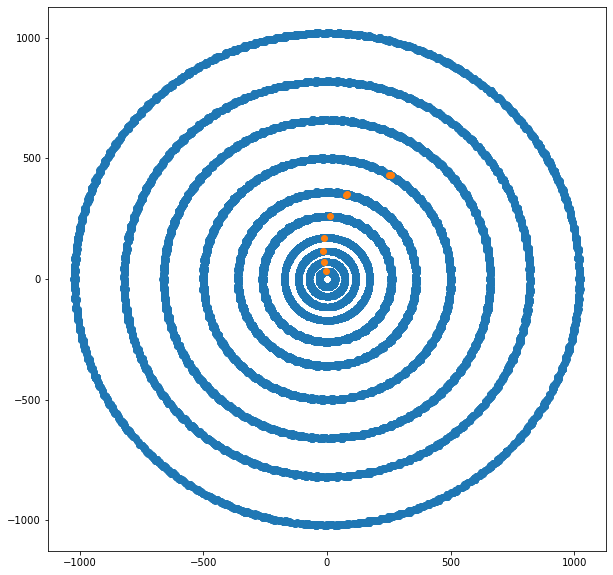

In [3]:
plt.figure(figsize=(10,10))
ax = plt.axes()
ax.plot(selected_hits.x, selected_hits.y, 'o')
ax.plot(track.tx, track.ty, 'o')
plt.show()

In [7]:
def convertTrackToImage(trackId):
    first = True
    numberBins = 500
    image = np.empty((numberBins, 0))
    for volume in [8, 13, 17]:
        #print(volume)
        for layer in hits[hits.volume_id == volume].layer_id.unique():
            #print(layer)
            truthVol8 = truth.iloc[hits.index[(hits.volume_id == volume)].tolist()]
            hitsVol8 = hits.iloc[hits.index[(hits.volume_id == volume)].tolist()]
            t = truthVol8.loc[(hitsVol8.layer_id == layer) & (truthVol8.particle_id == trackId)]
            r = np.power(t.tx, 2) + np.power(t.ty, 2)
            theta = np.arctan(t.ty / t.tx)
            thetaRange = np.pi*2
            indicesFloat = (theta / thetaRange) * numberBins + numberBins / 2
            indices = np.array(list(map(int, indicesFloat)))
            indices = np.reshape(indices, (len(indices), 1))
            bins = np.zeros((numberBins, 1))
            if first:
                if len(indices) == 0:
                    image = np.hstack([image, np.zeros((numberBins, 1))])
                    continue
                firstIndex = max(indices[0])
                moveRange = firstIndex - numberBins // 2
                first = False
            indices = (indices - moveRange) % numberBins
            for i, index in enumerate(indices):
                bins[index, 0] += 10
            image = np.hstack([image, bins])
            #print(indices)
    return image

In [12]:
images = []
#images_val = []
train_y = np.empty((0, 1))
for k in range(0, 20):
    print("round:", k)
    if k < 10:
        event_prefix = 'event00000100' + str(k)
    else:
        event_prefix = 'event00000101' + str(k - 10)
    hits, cells, particles, truth = load_event(os.path.join('train_100_events', event_prefix))
    cond = (hits['volume_id'] == 8) | (hits['volume_id'] == 13) | (hits['volume_id'] == 17)
    selected_indices = hits.index[cond].tolist()
    selected_hits = hits.iloc[selected_indices]
    selected_truth = truth.iloc[selected_indices]
    # Create training set with tracks that are minimum of 5 hits
    tracks = selected_truth.particle_id.unique()
    validTracks = []
    for track in tracks:
        if track == 0:
            continue
        numberHits = selected_truth[selected_truth.particle_id == track].shape[0]
        t = selected_truth[selected_truth.particle_id == track]
        first = len(t[t.tx > 0]) == len(t.tx) and len(t[t.ty > 0]) == len(t.ty)
    
        if numberHits >= 10 and first:
            validTracks.append(track)

    nr = len(validTracks)
    for j in tqdm(range(nr)):
        trackId = validTracks[j]
        image = convertTrackToImage(trackId)
        images.append(image)
        #print(c)
    # Create train_Y (the momentum)
    for j, track in enumerate(validTracks[0:nr]):
        if track == 0:
            continue
        t = selected_truth[selected_truth.particle_id == track]
        px = t['tpx'].mean()
        py = t['tpy'].mean()
        #pz = t['tpz'].mean()
        p = np.sqrt(px**2 + py**2) #+ pz**2)# / (0.3 * 0.001 * 2)
        train_y = np.append(train_y, [p])
    


round: 0


100%|████████████████████████████████████████████████████████████████████████████████| 323/323 [00:37<00:00,  8.60it/s]


round: 1


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:24<00:00,  9.59it/s]


round: 2


100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:47<00:00,  7.93it/s]


round: 3


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [00:29<00:00,  9.47it/s]


round: 4


100%|████████████████████████████████████████████████████████████████████████████████| 393/393 [00:51<00:00,  7.63it/s]


round: 5


100%|████████████████████████████████████████████████████████████████████████████████| 290/290 [00:34<00:00,  8.40it/s]


round: 6


100%|████████████████████████████████████████████████████████████████████████████████| 323/323 [00:39<00:00,  8.25it/s]


round: 7


100%|████████████████████████████████████████████████████████████████████████████████| 325/325 [00:39<00:00,  8.19it/s]


round: 8


100%|████████████████████████████████████████████████████████████████████████████████| 317/317 [00:40<00:00,  7.89it/s]


round: 9


100%|████████████████████████████████████████████████████████████████████████████████| 287/287 [00:36<00:00,  7.84it/s]


round: 10


100%|████████████████████████████████████████████████████████████████████████████████| 272/272 [00:34<00:00,  7.85it/s]


round: 11


100%|████████████████████████████████████████████████████████████████████████████████| 361/361 [00:50<00:00,  7.19it/s]


round: 12


100%|████████████████████████████████████████████████████████████████████████████████| 305/305 [00:41<00:00,  7.29it/s]


round: 13


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [00:40<00:00,  7.32it/s]


round: 14


100%|████████████████████████████████████████████████████████████████████████████████| 405/405 [01:00<00:00,  6.68it/s]


round: 15


100%|████████████████████████████████████████████████████████████████████████████████| 369/369 [00:55<00:00,  6.60it/s]


round: 16


100%|████████████████████████████████████████████████████████████████████████████████| 323/323 [00:49<00:00,  6.58it/s]


round: 17


100%|████████████████████████████████████████████████████████████████████████████████| 382/382 [00:59<00:00,  6.40it/s]


round: 18


100%|████████████████████████████████████████████████████████████████████████████████| 242/242 [00:33<00:00,  7.22it/s]


round: 19


100%|████████████████████████████████████████████████████████████████████████████████| 306/306 [00:49<00:00,  6.17it/s]


In [29]:
images_val = []
train_y_val = np.empty((0, 1))
for k in range(0, 5):
    print("round:", k)
    if k < 10:
        event_prefix = 'event00000100' + str(k)
    else:
        event_prefix = 'event00000102' + str(k)
    hits, cells, particles, truth = load_event(os.path.join('train_100_events', event_prefix))
    cond = (hits['volume_id'] == 8) | (hits['volume_id'] == 13) | (hits['volume_id'] == 17)
    selected_indices = hits.index[cond].tolist()
    selected_hits = hits.iloc[selected_indices]
    selected_truth = truth.iloc[selected_indices]
    # Create training set with tracks that are minimum of 5 hits
    tracks = selected_truth.particle_id.unique()
    validTracks = []
    for track in tracks:
        if track == 0:
            continue
        numberHits = selected_truth[selected_truth.particle_id == track].shape[0]
        t = selected_truth[selected_truth.particle_id == track]
        first = len(t[t.tx > 0]) == len(t.tx) and len(t[t.ty > 0]) == len(t.ty)
    
        if numberHits >= 10 and first:
            validTracks.append(track)

    nr = len(validTracks)
    for j in tqdm(range(nr)):
        trackId = validTracks[j]
        image = convertTrackToImage(trackId)
        images_val.append(image)
        #print(c)
    # Create train_Y (the momentum)
    for j, track in enumerate(validTracks[0:nr]):
        if track == 0:
            continue
        t = selected_truth[selected_truth.particle_id == track]
        px = t['tpx'].mean()
        py = t['tpy'].mean()
        #pz = t['tpz'].mean()
        p = np.sqrt(px**2 + py**2) #+ pz**2)# / (0.3 * 0.001 * 2)
        train_y_val = np.append(train_y_val, [p])
    


round: 0


100%|████████████████████████████████████████████████████████████████████████████████| 323/323 [01:08<00:00,  4.75it/s]


round: 1


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:44<00:00,  5.33it/s]


round: 2


100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [01:23<00:00,  4.45it/s]


round: 3


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [00:55<00:00,  4.97it/s]


round: 4


100%|████████████████████████████████████████████████████████████████████████████████| 393/393 [01:38<00:00,  4.00it/s]


In [13]:
print(len(images))
#for i in range(len(images)):
#    print(images[i].shape)

6406


In [15]:
#train_y = np.reshape(train_y, (len(train_y), 1))
#train_X = np.reshape(images, (len(images), 500, 10, 1))
#test_X = train_X[:50]
#test_Y = train_y[:50]
#train_X = train_X[50:]
#train_y = train_y[50:]

In [30]:
test_X = np.reshape(images_val, (len(images_val), 500, 10, 1))
test_y = np.reshape(train_y_val, (len(train_y_val), 1))

In [31]:
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

(6406, 500, 10, 1) (6406, 1)
(1601, 500, 10, 1) (1601, 1)


In [17]:
#y_range = (np.max(train_y) - np.min(train_y))
#mini = np.min(train_y)
#train_y = (train_y - mini) / y_range

In [18]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import layers

Using TensorFlow backend.


In [19]:
def build_model():
    model = keras.Sequential([
        layers.Conv2D(8, (3, 3), activation="relu", input_shape=(500, 10, 1)),
        #layers.Conv2D(8, (3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        #layers.Conv2D(8, (3, 3), activation="relu"),
        layers.Conv2D(16, (3, 3), activation="relu"),
        layers.Flatten(),
        layers.Dense(1)
    ])

    #optimizer = keras.optimizers.RMSprop(learning_rate=0.00001) #0.00001 works good
    model.compile(loss='mse', optimizer='adam')
    return model

In [20]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 498, 8, 8)         80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 249, 4, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 247, 2, 16)        1168      
_________________________________________________________________
flatten_1 (Flatten)          (None, 7904)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7905      
Total params: 9,153
Trainable params: 9,153
Non-trainable params: 0
_________________________________________________________________


In [21]:
EPOCHS = 2000
print(train_X.shape)
print(train_y.shape)
history = model.fit(train_X, train_y, validation_split=0.1, epochs=EPOCHS)

(6406, 500, 10, 1)
(6406, 1)
Train on 5765 samples, validate on 641 samples
Epoch 1/2000
5765/5765 [==============================] - 14s 2ms/step - loss: 2.1230 - val_loss: 0.1459
Epoch 2/2000
5765/5765 [==============================] - 13s 2ms/step - loss: 1.5256 - val_loss: 0.2821
Epoch 3/2000
5765/5765 [==============================] - 14s 2ms/step - loss: 1.2396 - val_loss: 0.1750
Epoch 4/2000
5765/5765 [==============================] - 14s 2ms/step - loss: 1.0226 - val_loss: 0.2066
Epoch 5/2000
5765/5765 [==============================] - 14s 2ms/step - loss: 0.8905 - val_loss: 0.2381
Epoch 6/2000
5765/5765 [==============================] - 15s 3ms/step - loss: 0.7555 - val_loss: 0.1689
Epoch 7/2000
5765/5765 [==============================] - 14s 2ms/step - loss: 0.7228 - val_loss: 0.1474
Epoch 8/2000
5765/5765 [==============================] - 13s 2ms/step - loss: 0.5966 - val_loss: 0.1604
Epoch 9/2000
5765/5765 [==============================] - 14s 2ms/step - loss: 0.693

5765/5765 [==============================] - 12s 2ms/step - loss: 0.0412 - val_loss: 0.0895
Epoch 78/2000
5765/5765 [==============================] - 12s 2ms/step - loss: 0.0431 - val_loss: 0.0689
Epoch 79/2000
5765/5765 [==============================] - 12s 2ms/step - loss: 0.0281 - val_loss: 0.0664
Epoch 80/2000
5765/5765 [==============================] - 12s 2ms/step - loss: 0.0335 - val_loss: 0.0902
Epoch 81/2000
5765/5765 [==============================] - 12s 2ms/step - loss: 0.0753 - val_loss: 0.0753
Epoch 82/2000
5765/5765 [==============================] - 11s 2ms/step - loss: 0.0328 - val_loss: 0.0697
Epoch 83/2000
5765/5765 [==============================] - 11s 2ms/step - loss: 0.0372 - val_loss: 0.0951
Epoch 84/2000
5765/5765 [==============================] - 12s 2ms/step - loss: 0.0458 - val_loss: 0.0677
Epoch 85/2000
5765/5765 [==============================] - 11s 2ms/step - loss: 0.0519 - val_loss: 0.0698
Epoch 86/2000
5765/5765 [==============================] - 1

5765/5765 [==============================] - 11s 2ms/step - loss: 0.0518 - val_loss: 0.0485
Epoch 154/2000
5765/5765 [==============================] - 12s 2ms/step - loss: 0.0151 - val_loss: 0.0441
Epoch 155/2000
5765/5765 [==============================] - 11s 2ms/step - loss: 0.0156 - val_loss: 0.0661
Epoch 156/2000
5765/5765 [==============================] - 11s 2ms/step - loss: 0.0292 - val_loss: 0.0572
Epoch 157/2000
5765/5765 [==============================] - 12s 2ms/step - loss: 0.0256 - val_loss: 0.0502
Epoch 158/2000
5765/5765 [==============================] - 12s 2ms/step - loss: 0.0256 - val_loss: 0.0498
Epoch 159/2000
5765/5765 [==============================] - 11s 2ms/step - loss: 0.0166 - val_loss: 0.0563
Epoch 160/2000
5765/5765 [==============================] - 11s 2ms/step - loss: 0.0141 - val_loss: 0.0473
Epoch 161/2000
5765/5765 [==============================] - 10s 2ms/step - loss: 0.0135 - val_loss: 0.0596
Epoch 162/2000
5765/5765 [==========================

KeyboardInterrupt: 

In [42]:
i = 991
prediction = model.predict(np.reshape(test_X[i], (1, 500, 10, 1)))
print(prediction, " ", test_y[i])

[[0.88023686]]   [0.88756629]


In [45]:
percentages = []
for i in range(len(test_X)):
    prediction = model.predict(np.reshape(test_X[i], (1, 500, 10, 1)))
    percentages.append(abs((prediction - test_y[i]) / test_y[i]) * 100)
percentages = np.array(percentages)
print(np.mean(percentages))

15.533902558839031
